# Makam similarity through feature extraction

Sergio Gor Bravo, NIA:173592

Enric Gusó Muñoz, NIA:122049

21st March 2019

# Data preparation

In [1]:
import os
# First we list all the files
scorelist=os.listdir('SymbTr-master/txt')
# Filter out the ones that are not .txt
scorelist = [k for k in scorelist if '.txt' in k]
scorelist.sort()
makamscore_dir = list()
# Nest by makam
for score in scorelist:
    makam = {'makam':score.split('--')[0], 'scores':[k for k in scorelist if score.split('--')[0] == k.split('--')[0]]}
    if makam not in makamscore_dir:
        makamscore_dir.append(makam)
# Sort makams by number of scores
makamscore_dir.sort(key=lambda k:len(k['scores']), reverse=True)

# Feature extraction

In [2]:
from collections import Counter

def normalize(items_list):
    # Normalize the data
    if type(items_list) == dict:
        d_aux = items_list
        d_out = dict()
        for word in d_aux:
            num_items = Counter()
            items = d_aux[word]
            for item in items:
                num_items[str(item)] += 1/len(items)
            d_out[word] = dict(num_items)
        return d_out
    else:
        num_items = Counter()
        for item in items_list:
            num_items[str(item)] += 1/len(items_list)
        return dict(num_items)


def extract_intervals(df):
    # Returns intervals between all pairs of consecutive notes
    intervals = list()
    for i in range(len(df)-1):
        # check if current note or next note are silence or usul change
        if (9 <= int(df['Kod'].iloc[i]) <= 10) and (9 >= int(df['Kod'].iloc[i+1]) <= 10) and (int(df['Koma53'].iloc[i]) != -1) and (int(df['Koma53'].iloc[i+1]) != -1):
            intervals.append(int(df['Koma53'].iloc[i+1]) - int(df['Koma53'].iloc[i]))
        else: 
            continue
            
    return intervals

def relevant_notes(df):
    # Returns first, second last and last notes
    notes = list()
    for i in range(len(df)):
        if 9 <= int(df['Kod'].iloc[i]) <= 10 and int(df['Koma53'].iloc[i]) != -1:
            first = int(df['Koma53'].iloc[i])
            break
    for i in range(len(df)-1, 0, -1):
        if 9 <= int(df['Kod'].iloc[i]) <= 10 and int(df['Koma53'].iloc[i]) != -1:
            sec_last = (int(df['Koma53'].iloc[i-1]))
            last = (int(df['Koma53'].iloc[i]))
            break
    return first, sec_last, last

def mode_note(df):
    # removes silences 
    auxdf = df[~df['Koma53'].isin(['-1'])]
    # return mode of notes
    return list(auxdf[auxdf['Kod'].isin(['9', '10'])]['Koma53'].mode().values)


def extract_sequences(df, num_notes):
    # Returns intervals of 'num_notes' consecutive notes
    seqs = list()
    on_seq = False
    sequence = list()    
    for i in range(len(df)-1):
        # check if current note or next note are silence or usul change
        if (9 <= int(df['Kod'].iloc[i]) <= 10) and (9 >= int(df['Kod'].iloc[i+1]) <= 10) and (int(df['Koma53'].iloc[i]) != -1) and (int(df['Koma53'].iloc[i+1]) != -1):
            if (len(sequence) < num_notes-1):
                on_seq = True
                sequence.append(int(df['Koma53'].iloc[i+1]) - int(df['Koma53'].iloc[i]))
            else:
                if (len(sequence) == num_notes-1):
                    seqs.append(sequence)
                sequence = list()
                on_seq = False  
        else:
            #if still storing sequence and sequence has the desired duration => stop
            if on_seq and len(sequence)== num_notes-1:
                seqs.append(sequence)
            sequence = list()
            on_seq = False               
            
                    
    return seqs

def extract_motifs(df):
    motifs = list()
    on_motif = False
    motif = list()
    for i in range(len(df)-1):
        # check if current note or next note are silence or usul change
        if (8 <= int(df['Kod'].iloc[i]) <= 10 and 8 <= int(df['Kod'].iloc[i+1]) <= 10):
            on_motif = True
            motif.append(int(df['Koma53'].iloc[i+1]) - int(df['Koma53'].iloc[i]))
        else:
            if int(df['Kod'].iloc[i+1]) == 53:
                motifs.append(motif)
            motif = list()
            on_motif = False
    return motifs

In [3]:
import pandas as pd

columns = ['Sira', 'Kod', 'Nota53', 'NotaAE', 'Koma53', 'KomaAE', 'Pay', 'Payda', 'Ms', 'LNS', 'Bas', 'Soz1', 'Offset']
makam_features = dict()

path = './SymbTr-master/txt/'
# Top 5 of makams with most scores
makamscore_top5 = makamscore_dir[:5]
for makam in makamscore_top5:
    # Init features
    intervals = list()
    firsts = list()
    sec_lasts = list()
    lasts = list()
    md_note = list()
    motifs = list()
    seqs = dict()
    
    print('Processing ' +  makam['makam'] + ' scores:')
    
    # This loop computes the features of all the scores of each makam
    for i, file in enumerate(makam['scores']):
        # print files remaining
        if i%25 == 0:
            print('  '+str(len(makam['scores']) -i) + ' files remaining')
            
        # Cast .txt to DataFrame
        df = pd.DataFrame(columns = columns)
        with open(path + file) as f: 
            for n, line in enumerate(f):
                if n > 0:
                    auxdf = pd.DataFrame(data = line.strip().split("\t")).T
                    auxdf.columns = columns
                    df = df.append(auxdf)
        # Extract features
        intervals += extract_intervals(df)
        first, sec_last, last  = relevant_notes(df)
        firsts.append(first)
        sec_lasts.append(sec_last)
        lasts.append(last)
        aux = mode_note(df)
        # if more than 1 mode note, save both
        for i in range(len(aux)):
            md_note.append(int(aux[i]))
        for j in range(3,13):
            seqs['Intrvls of ' + str(j) + ' consec. notes'] = extract_sequences(df, j)
        # if motif exists
        aux = extract_motifs(df)
        if len(aux) > 0:
            motifs += aux
    
    # Insert into makams dict, normalized
    makam_features[makam['makam']] = dict()
    makam_features[makam['makam']]['norm'] = dict()
    makam_features[makam['makam']]['norm']['intervals'] = normalize(intervals)
    makam_features[makam['makam']]['norm']['firsts'] = normalize(firsts)
    makam_features[makam['makam']]['norm']['second lasts'] = normalize(sec_lasts)
    makam_features[makam['makam']]['norm']['lasts'] = normalize(lasts)
    makam_features[makam['makam']]['norm']['mode note'] = normalize(md_note) 
    for i in seqs:
        makam_features[makam['makam']]['norm']['sequences'] = normalize(seqs)
    makam_features[makam['makam']]['norm']['motifs'] = normalize(motifs)
    
    # No normalization
    makam_features[makam['makam']]['not norm'] = dict()
    makam_features[makam['makam']]['not norm']['intervals'] = intervals
    makam_features[makam['makam']]['not norm']['firsts'] = firsts
    makam_features[makam['makam']]['not norm']['second lasts'] = sec_lasts
    makam_features[makam['makam']]['not norm']['lasts'] = lasts
    makam_features[makam['makam']]['not norm']['mode note'] = md_note
    for i in seqs:
        makam_features[makam['makam']]['not norm']['sequences'] = seqs
    makam_features[makam['makam']]['not norm']['motifs'] = motifs



Processing hicaz scores:
  157 files remaining
  132 files remaining
  107 files remaining
  82 files remaining
  57 files remaining
  32 files remaining
  7 files remaining
Processing nihavent scores:
  130 files remaining
  105 files remaining
  80 files remaining
  55 files remaining
  30 files remaining
  5 files remaining
Processing ussak scores:
  118 files remaining
  93 files remaining
  68 files remaining
  43 files remaining
  18 files remaining
Processing rast scores:
  109 files remaining
  84 files remaining
  59 files remaining
  34 files remaining
  9 files remaining
Processing huzzam scores:
  96 files remaining
  71 files remaining
  46 files remaining
  21 files remaining


# Intervals

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(5,1, figsize=(20,15), sharex = True, sharey = True)
for idx, i in enumerate(makam_features):   
    lists = sorted(makam_features[i]['norm']['intervals'].items()) # sorted by key, return a list of tuples
    aux = list()
    for j in lists:
        aux.append([int(j[0]), j[1]])
    lists = sorted(aux)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    ax[idx].bar(x,y)
    ax[idx].set_title(str(i) + ' intervals')
    ax[idx].xaxis.set_tick_params(which='both', labelbottom=True)

_=plt.xticks(np.arange(-50, 50, 5))
_=plt.xlim(-35,45)
plt.tight_layout()
plt.savefig('./figures/intervals.png')

# Mode note

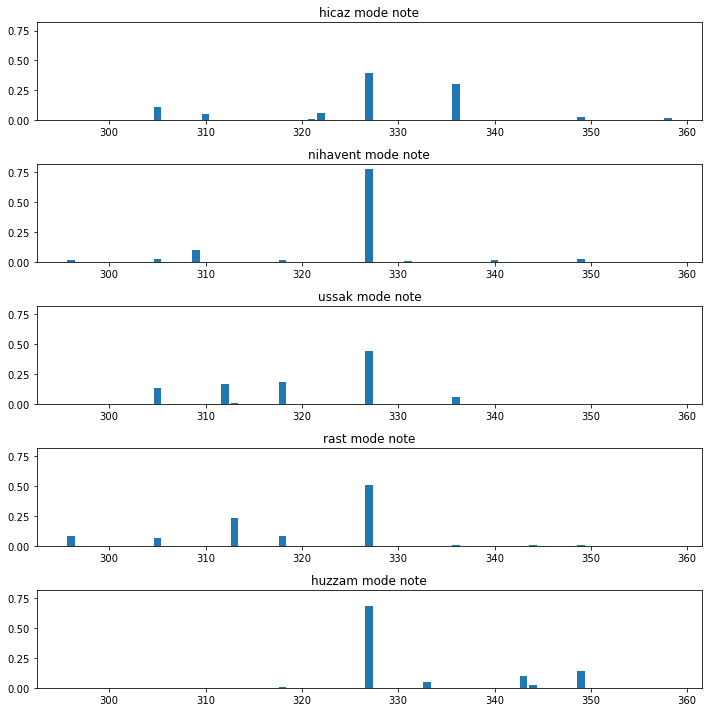

In [5]:
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex = True, sharey = True)
for idx, i in enumerate(makam_features):   
    lists = sorted(makam_features[i]['norm']['mode note'].items()) # sorted by key, return a list of tuples
    aux = list()
    for j in lists:
        aux.append([int(j[0]), j[1]])
    lists = sorted(aux)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    ax[idx].bar(x,y)
    ax[idx].set_title(str(i) + ' mode note')
    ax[idx].xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()
plt.savefig('./figures/mode_note.png')

# First note

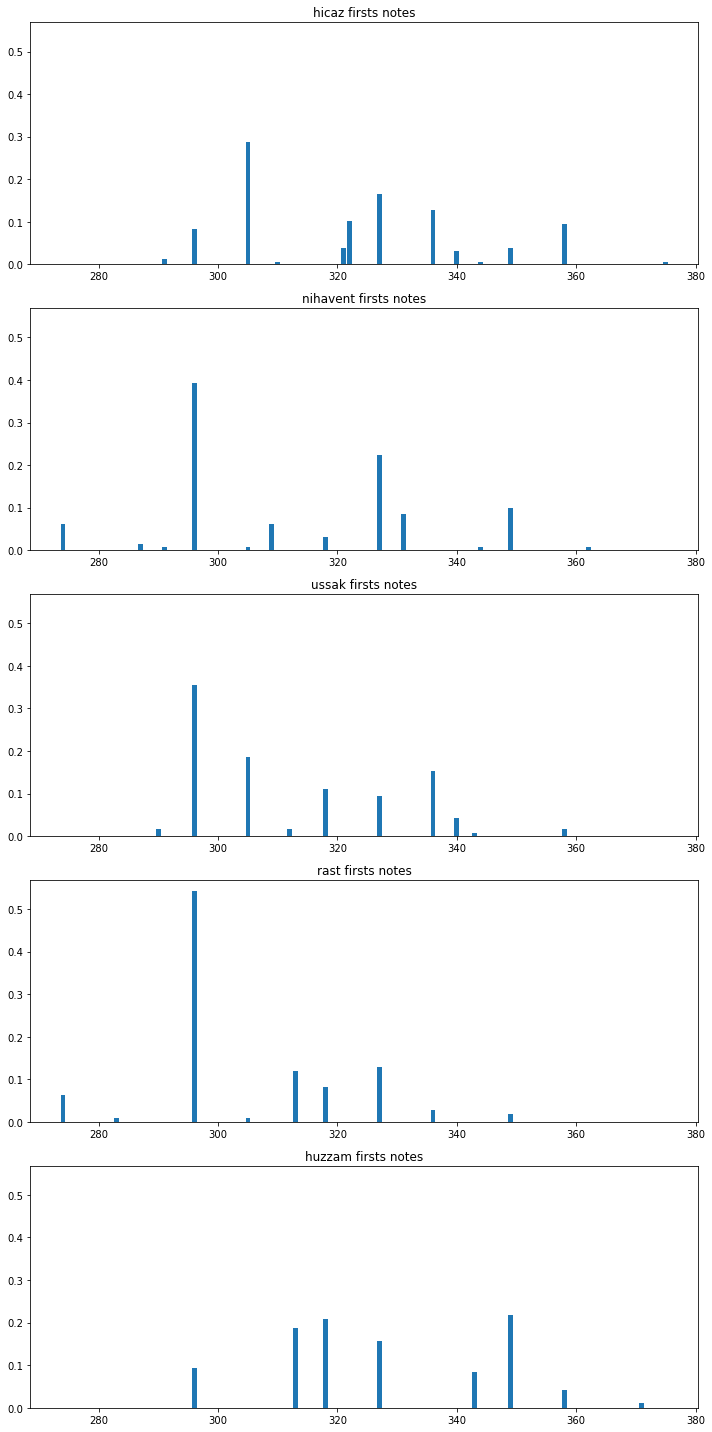

In [6]:
fig, ax = plt.subplots(5,1, figsize=(10,20), sharey = True, sharex = True)
for idx, i in enumerate(makam_features): 
    lists = sorted(makam_features[i]['norm']['firsts'].items()) # sorted by key, return a list of tuples
    aux = list()
    for j in lists:
        aux.append([int(j[0]), j[1]])
    lists = sorted(aux)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    ax[idx].bar(x,y)
    ax[idx].set_title(str(i) + ' firsts notes')
    ax[idx].xaxis.set_tick_params(which='both', labelbottom=True)
    
plt.tight_layout()
plt.savefig('./figures/first_notes.png')

# Second last notes

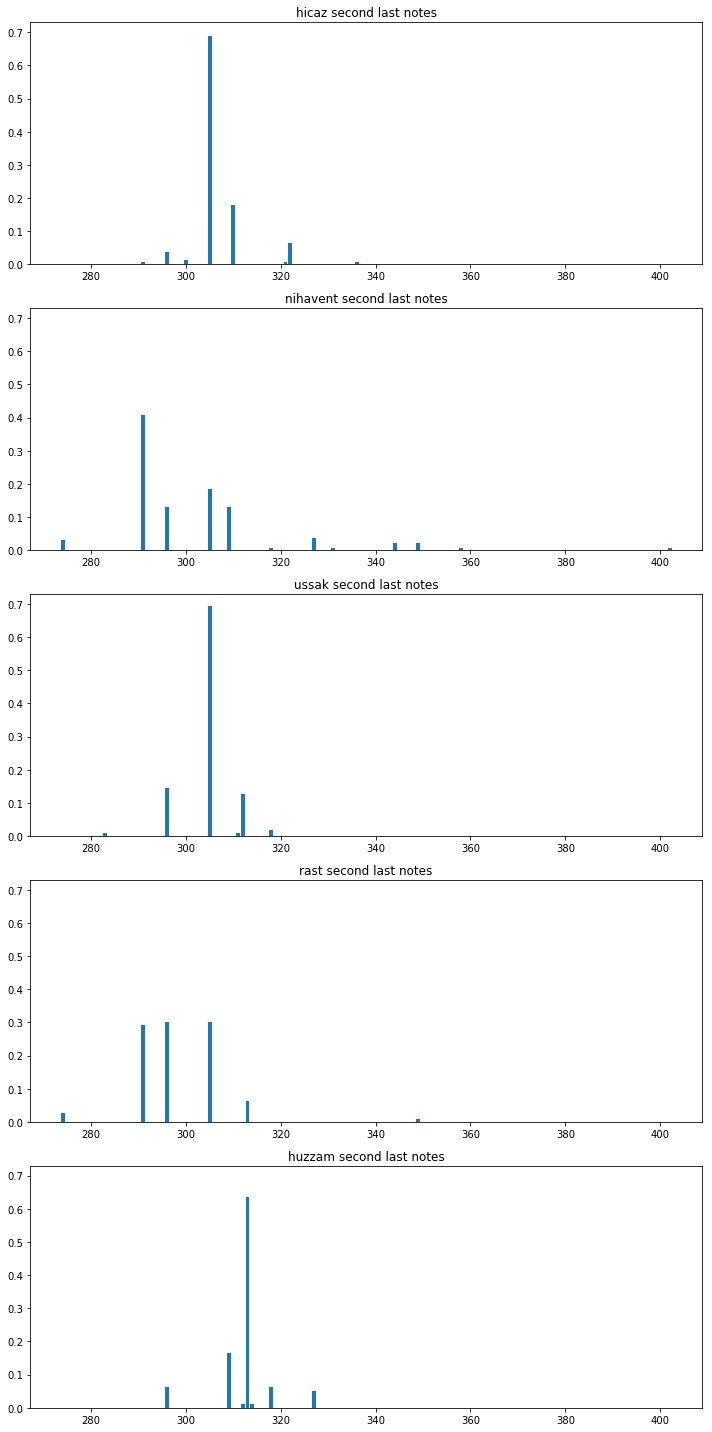

In [7]:
fig, ax = plt.subplots(5,1, figsize=(10,20), sharey = True, sharex = True)
for idx, i in enumerate(makam_features): 
    lists = sorted(makam_features[i]['norm']['second lasts'].items()) # sorted by key, return a list of tuples
    aux = list()
    for j in lists:
        aux.append([int(j[0]), j[1]])
    lists = sorted(aux)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    ax[idx].bar(x,y)
    ax[idx].set_title(str(i) + ' second last notes')
    ax[idx].xaxis.set_tick_params(which='both', labelbottom=True)
    
plt.tight_layout()
plt.savefig('./figures/second_last_notes.png')

# Last notes

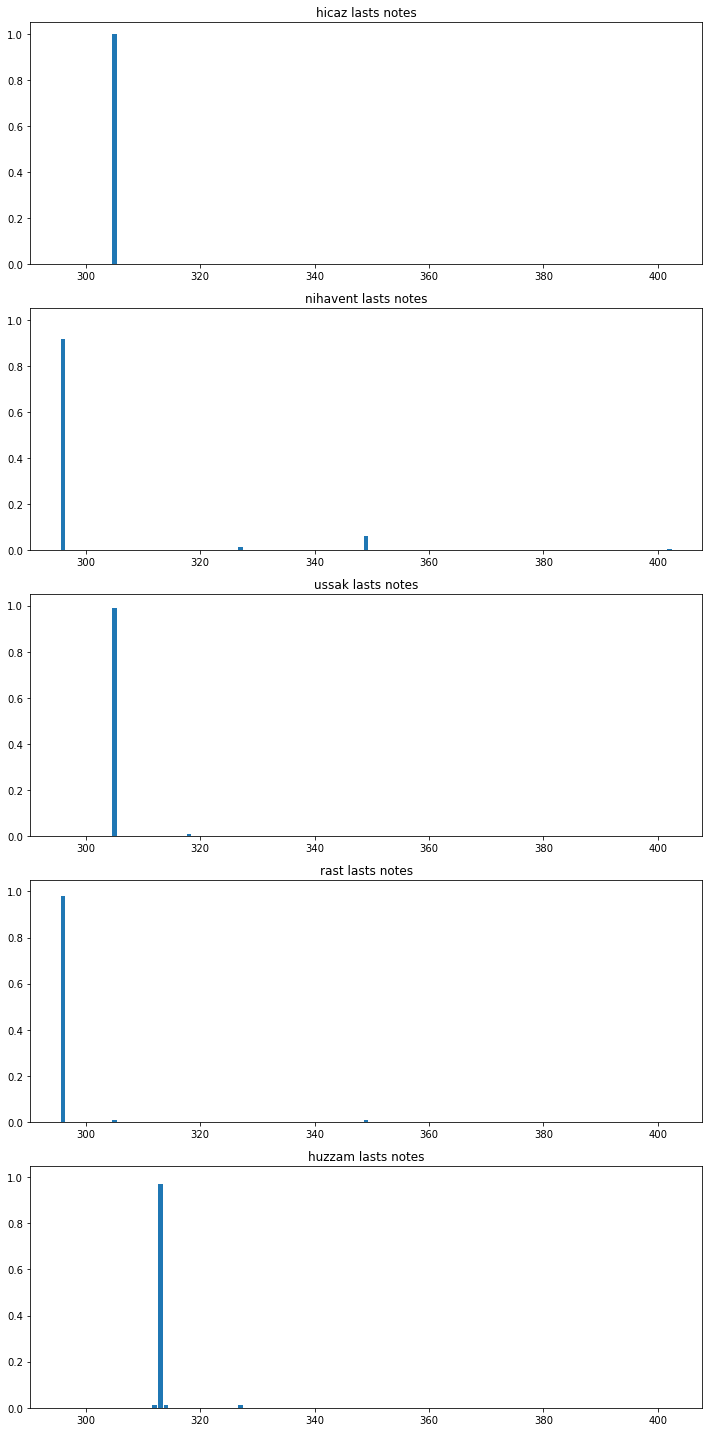

In [8]:
fig, ax = plt.subplots(5,1, figsize=(10,20), sharey = True, sharex = True)
for idx, i in enumerate(makam_features): 
    lists = sorted(makam_features[i]['norm']['lasts'].items()) # sorted by key, return a list of tuples
    aux = list()
    for j in lists:
        aux.append([int(j[0]), j[1]])
    lists = sorted(aux)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    ax[idx].bar(x,y)
    ax[idx].set_title(str(i) + ' lasts notes')
    ax[idx].xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()
plt.savefig('./figures/last_notes.png')



# Similarity 

In [9]:
def similarity_feature(makam1, makam2, feature, consec_notes = None):
    # Compute feature similarity between makam1 and makam2. If feature == 'sequences' consec_notes needs to be
    # the number of consecutive notes to evaluate
    
    if feature == 'sequences':
        mak1 = makam1['norm'][feature]['Intrvls of ' + str(consec_notes) + ' consec. notes'].copy()
        mak2 = makam2['norm'][feature]['Intrvls of '+ str(consec_notes) + ' consec. notes'].copy()
        
        mak1_unnorm = makam1['not norm'][feature]['Intrvls of ' + str(consec_notes) + ' consec. notes'].copy()
        mak2_unnorm = makam2['not norm'][feature]['Intrvls of '+ str(consec_notes) + ' consec. notes'].copy()
    else:
        mak1 = makam1['norm'][feature].copy()
        mak2 = makam2['norm'][feature].copy()
        
        mak1_unnorm = makam1['not norm'][feature].copy()
        mak2_unnorm = makam2['not norm'][feature].copy()
    
    for key in mak1.keys():
        if key in mak2:
            continue
        else:
            mak2[key] = 0
    for key in mak2.keys():
        if key in mak1:
            continue
        else:
            mak1[key] = 0
    mak1 = sorted(mak1.items()) # sorted by key, return a list of tuples
    aux = list()
    for j in mak1:
        if feature == 'motifs' or feature == 'sequences':
            aux.append([(j[0]), j[1]])
        else:
            aux.append([int(j[0]), j[1]])
    mak1 = sorted(aux)

    mak2 = sorted(mak2.items()) # sorted by key, return a list of tuples
    aux = list()
    for j in mak2:
        if feature == 'motifs' or feature == 'sequences':
            aux.append([(j[0]), j[1]])
        else:
            aux.append([int(j[0]), j[1]])
    mak2 = sorted(aux)
    _, mak2_den = zip(*mak2) # unpack a list of pairs into two tuples 
    _, mak1_den = zip(*mak1) # unpack a list of pairs into two tuples 
    mak2_den = np.asarray(mak2_den)
    mak1_den = np.asarray(mak1_den)
    
    # Append mean and std of the selected features        
    mak1_den = np.append(mak1_den, np.mean(mak1_unnorm))
    mak1_den = np.append(mak1_den, np.std(mak1_unnorm))

    mak2_den = np.append(mak2_den, np.mean(mak2_unnorm))
    mak2_den = np.append(mak2_den, np.std(mak2_unnorm))
    
    return sum(np.power((mak1_den-mak2_den),2))

def compute_similarity_distance(makam1, makam2):
    
    sim = np.zeros((8,1))
    sim[0] = similarity_feature(makam1, makam2, 'intervals')
    sim[1] = similarity_feature(makam1, makam2, 'mode note')
    sim[2] = similarity_feature(makam1, makam2, 'firsts')
    sim[3] = similarity_feature(makam1, makam2, 'second lasts')
    sim[4] = similarity_feature(makam1, makam2, 'lasts')
    sim[5] = similarity_feature(makam1, makam2, 'sequences', 3)
    sim[6] = similarity_feature(makam1, makam2, 'sequences', 4)
    sim[7] = similarity_feature(makam1, makam2, 'sequences', 5)
    
    return np.sqrt(sum(sim))



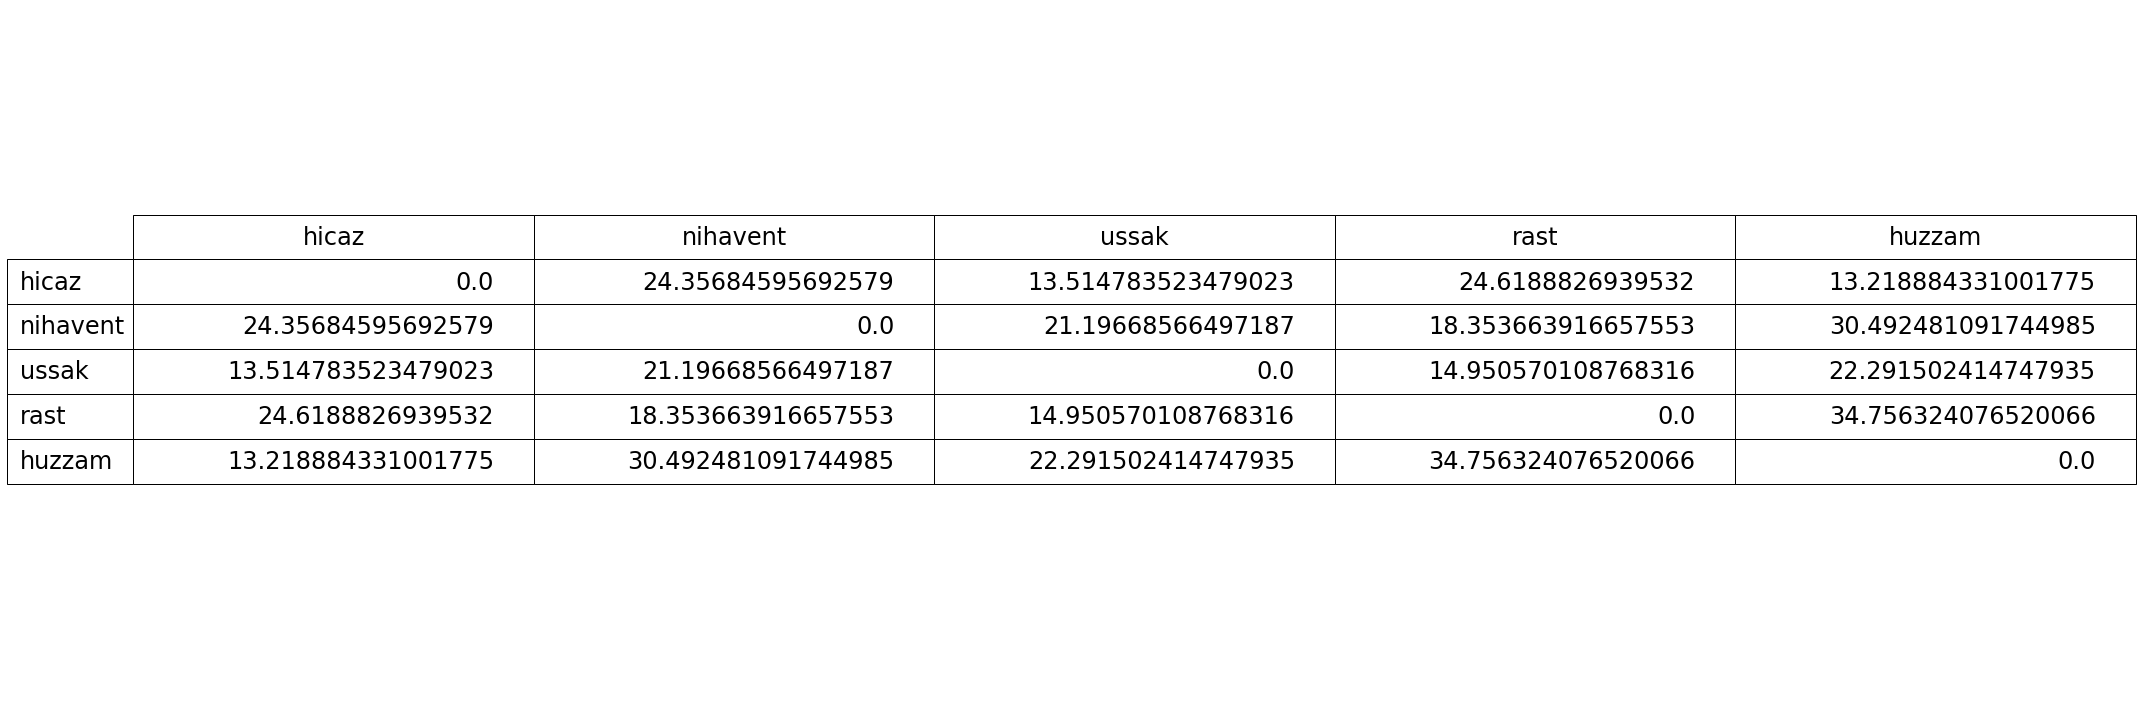

In [12]:
rows= list()
cell_text = np.zeros((5,5))
for idx1, i in enumerate(makam_features):
    rows.append(i)
    for idx2, j in enumerate(makam_features):
        cell_text[idx1][idx2] = compute_similarity_distance(makam_features[i] ,makam_features[j])
cols = rows
plt.figure(figsize=(10,10))
plt.axis('off')
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=cols,
                      loc='center')
the_table.scale(1.5, 1.5) 
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.tight_layout()
plt.savefig('./figures/similarity_table.png')